# Verification and Hyperparameters

## 1. Metrics
#### Bias
description

$$
Bias = \sum_{n=1}^N   | \hat{y}_n - y_n |
$$

#### RMSE
description
$$
RMSE =\sqrt{ \sum_{n=1}^N  (\hat{y}_n - y_n)^2 }
$$

#### Nash-Sutcliffe-Efficiency

The classical version after Nash and Sutcliffe (1970) compares the squared error of the discharge forecast ($\hat{y}$) with the squared error of forecasting the mean discharge ($\overline{y}$). It is framed as skill-score, where larger values are better. In its formula, we need to sum over all $N$ forecasts:

$$
NSE = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{( \overline{y} - y_n)^2} 
$$



Equivalently, the NSE can be seen as error reduction with respect to the reference forecast divided by the error of the reference forecast:

$$
NSE = \frac{\epsilon^2_{ref} - \epsilon^2}{\epsilon^2_{ref}}
$$
Thus, the idea of the NSE is that valuable predictions exhibit values $>0$ and reaches at most one.


#### Alternative Nash-Sutcliffe-Efficiency (for predicting differences)
When we start our prediction at time $t$, we can use the current discharge to predict tomorrow's discharge. This means that we are essentially predicting just differences in discharge.

Now that we use the discharge information at forecast init time (=analysis time), we observe another issue to preserve the idea of the NSE score.

Think of a model that is constantly predicting just the initial discharge value. Such a model can be close to the truth without adding predictive value. In the classical NSE however, such a model would have a high NSE, since the deviations from the truth are small.

Thus, to keep the interpretation of the NSE (comparing to the easiest forecast), we divide by the variance of the error of a persistence forecast ( $ \overline{y} \leftarrow $persistence). This formulation yields a NSE* of 0 when the forecast is just predicting the initial discharge value. The best achievable value is still 1.

$$
NSE^* = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{(y_n - y_{persistence})^2} 
$$


## 2. Model evaluation

In [10]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import xarray as xr

import sys
sys.path.append('../../')
from python.aux.plot import plot_recurrent
from python.aux.utils import xr_to_datetime
from python.aux.utils_floodmodel import add_valid_time
from python.aux.verification import verify # ME, RMSE, RMSE_persistence, NSE, NSE_diff

### Load the "truth" (reanalysis) at the test gridpoint

In [3]:
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
dis = glofas['dis']

lat, lon = 48.35, 13.95  # the point where predictions are made
truth = dis.interp(latitude=lat, longitude=lon)

## 2.1 Time-delay neural net predictions

In [4]:
def open_prediction(path):
    """Convenience function"""
    pred = xr.open_dataset(path).to_array().squeeze().drop(['variable', 'name'])
    pred = add_valid_time(pred)
    return pred

model_dir = '../../models/'

In [5]:
model_name = model_dir+'tdnn-catchment_mean-differences-nosnow/'

In [6]:
validation = open_prediction(model_name+'/validation.nc')
test = open_prediction(model_name+'/test.nc')

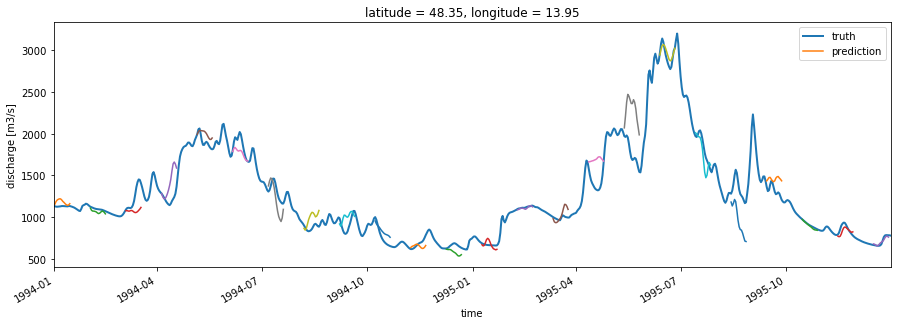

In [7]:
test_time = slice('1994', '1995')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=test_time), 
                   prediction=test, each_N=31)

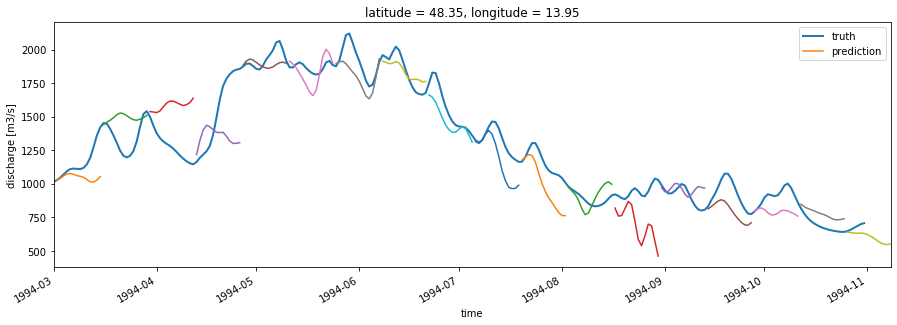

In [8]:
time=slice('1994-03', '1994-10')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=time),
                   prediction=test.sel(init_time=time), each_N=14)

In [11]:
d = verify(test, truth)

forecast-day: 1
0.17266703700899932 0.9917133931735995
forecast-day: 2
0.2246539483395441 0.9706091324371007
forecast-day: 3
0.2429628574508106 0.9437736329303249
forecast-day: 4
0.22366922942855438 0.9161788724167311
forecast-day: 5
0.21480692880516628 0.889522837660504
forecast-day: 6
0.22034946565452118 0.8640018781734873
forecast-day: 7
0.22691503541606317 0.8400801220555025
forecast-day: 8
0.23610457020176223 0.8184416478203005
forecast-day: 9
0.24921059045344185 0.7992078662630502
forecast-day: 10
0.2512667321427786 0.7813986420108606
forecast-day: 11
0.25770210232418445 0.7635137544127207
forecast-day: 12
0.27689075057196544 0.7445372840291402
forecast-day: 13
0.29539343627492487 0.7242022914535796
forecast-day: 14
0.31601301411942007 0.7026845676034461


In [12]:
d.ME

forecast_day
1.0     -1.426049
2.0     -3.687984
3.0     -5.511739
4.0     -4.648467
5.0     -3.316057
6.0     -5.342129
7.0    -10.212318
8.0    -16.635399
9.0    -21.196974
10.0   -23.592769
11.0   -26.012157
12.0   -27.716327
13.0   -28.713625
14.0   -26.058403
Name: ME, dtype: float64

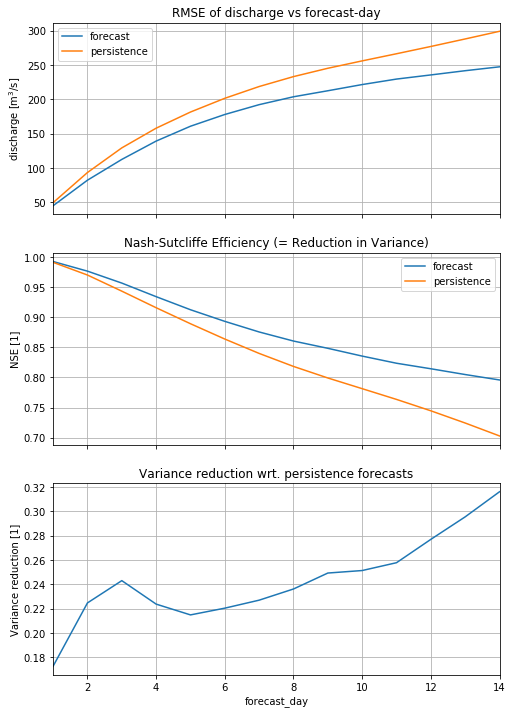

In [18]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,12))
d.RMSE.plot(ax=ax[0], label='forecast')
d.RMSE_persistence.plot(ax=ax[0], label='persistence',
                        title='RMSE of discharge vs forecast-day')
ax[0].set_ylabel('discharge [m$^3$/s]')
ax[0].legend()

d.NSE.plot(ax=ax[1], label='forecast',
           title='Nash-Sutcliffe Efficiency (= Reduction in Variance)')
d.NSE_persistence.plot(ax=ax[1], label='persistence')
ax[1].set_ylabel('NSE [1]')
ax[1].legend()

d.VR_persistence.plot(ax=ax[2], title="Variance reduction wrt. persistence forecasts")
ax[2].set_ylabel('Variance reduction [1]')

for axis in ax:
    axis.grid()

## 2.2 Time-convolutional neural net predictions